# Numeracy Intervention Analysis File

This file is the companion of the manuscript titled "Numeracy intervention for remedying the impact of school mobility", submitted to the University of Sunderland as assessment of module EDE314 Experiences of Teaching".

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Mapping from concepts to questions in the survey
labels2q = {'Success': (1, 2), 'Interest': (3, 4, 5), 'Utility': (6, 13, 7), 'Mastery': (8, 9), 'Performance': (10, 11)}
# questions that have a reversed scale (1-10)
reverse = 4

df = pd.read_csv('Survey Learning.csv')
questions = list(df.columns.values)
#reverse score of questions with the reversed scale
df.loc[:,questions[reverse]] = 10 - df[[reverse]]

# calculate the total scores for each group concept.
groups = pd.DataFrame()
for name, q in labels2q.items():
    print('Concept {} with {} questions'.format(name, len(q)))
    for qs in q:
        print(questions[qs].rjust(110,'*'))
    totalScore = df[list(q)].sum(axis=1)
    groups[name] = totalScore   

N = int(groups[[0]].count())

Concept Utility with 3 questions
*****************************I think what we are studying in introduction to robotics class is useful to know.
******************************************************I find the content of this course personally meaningful.
*************************************I can see how what I learn from robotics and engineering applies to life.
Concept Success with 2 questions
****************************************************************************I expect to do well in this class.
****************Considering the difficulty of this course and my skills, I think I will do well in this class.
Concept Interest with 3 questions
******************************************************************I think the field of robotics is interesting
***********************************************To be honest, I just don’t find science/engineering interesting
*****************************************************I think what we’re learning in this class is interesting.
Concept Mast

In [4]:
# Show the concepts and scores
groups

,Utility,Success,Interest,Mastery,Performance
0,15,12,20,10,7
1,17,9,18,11,11
2,19,12,22,13,14
3,21,12,23,13,12
4,18,11,22,12,2
5,19,11,20,12,12
6,17,11,20,14,11
7,21,12,23,14,14
8,18,11,22,14,14
9,21,14,23,14,7


## Calculate Cronbach's Alpha

Cronbach's alpha ($\alpha$) is also include to assess the consistency of these values under the implicit assumption that the averaged correlation of a set of self-reported values is an accurate estimator of the set of items that belong to a certain construct. A Cronbach's alpha value close to one indicates that the set of values from the survey correspond to the same concept. Conversely, a small $\alpha$ value suggest that the survey has a low number of questions or poor interrelatedness \parencite{tavakol2011making}. $\alpha$ is calculated as follows:
$$\alpha = \frac{K}{K-1} \left(1-\frac{\sum_{i=1}^K \sigma^2_{Y_i}}{ \sigma^2_X}\right)$$

In [5]:
for name, q in labels2q.items():
    sigmaY = df[list(q)].var(axis=0)
    sigmaX = df[list(q)].sum(axis=1).var()
    K = len(q)
    alpha = K/(K-1)*(1-sigmaY.sum()/sigmaX)
    print('Concept: {:15} with Cronbach\' alpha of {:.3}'.format(name,alpha))


Concept: Utility         with Cronbach' alpha of 0.777
Concept: Success         with Cronbach' alpha of 0.564
Concept: Interest        with Cronbach' alpha of 0.795
Concept: Mastery         with Cronbach' alpha of 0.798
Concept: Performance     with Cronbach' alpha of 0.492


## High and low expentancy of success groups

Two diferent groups are considered in here, a groups with low expentancy of success (-1 s.d) and high expentancy of success (+1 s.d).

In [6]:
meanSuccess = groups[['Success']].mean()
sdSuccess = groups[['Success']].std()
lowExpThres = float(np.ceil(meanSuccess - sdSuccess))
highExpThres = float(np.floor(meanSuccess + sdSuccess))

print('Thresholds for low ({}) and high ({}) expentancy groups'.format(lowExpThres, highExpThres))

label = ['' for n in range(N)]
for i, l in enumerate((groups[['Success']] <= lowExpThres).iterrows()):
    if l[1][0]:label[i] = 'low'
for i, h in enumerate((groups[['Success']] >= highExpThres).iterrows()):
    if h[1][0]:label[i] = 'high'

# encode df.famhist as a numeric via pd.Factor
groups['labels'] = pd.Categorical(label)
groups

Thresholds for low (11.0) and high (13.0) expentancy groups


,Utility,Success,Interest,Mastery,Performance,labels
0,15,12,20,10,7,
1,17,9,18,11,11,low
2,19,12,22,13,14,
3,21,12,23,13,12,
4,18,11,22,12,2,low
5,19,11,20,12,12,low
6,17,11,20,14,11,low
7,21,12,23,14,14,
8,18,11,22,14,14,low
9,21,14,23,14,7,high


## Multiple regression modeling

The multiple regression model describes the score values as a weighted sum of the predictors.The first model correspond to the the two variables Success and Mastery and how they predict the scores is:

$Interest=\beta_0+\beta_1\cdot Success$

In [7]:
est = smf.ols(formula='Interest ~ Success', data=groups).fit()

from IPython.core.display import HTML
def short_summary(est):
    return HTML(est.summary().tables[1].as_html())

short_summary(est)


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,11.3713,2.965,3.835,0.002,4.966 17.777
Success,0.8366,0.244,3.426,0.005,0.309 1.364


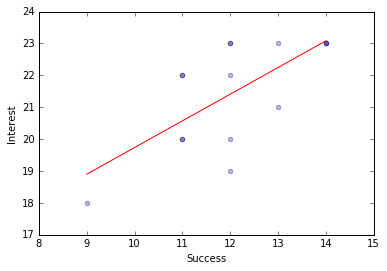

In [8]:
Success_linspace = np.linspace(groups.Success.min(), groups.Success.max(), 100)

plt.xlabel('Success')
plt.ylabel('Interest')
plt.scatter(groups.Success, groups.Interest, alpha=0.3)
plt.plot(Success_linspace, est.params[0] + est.params[1] * Success_linspace, 'r')

## Model \#2:  Prediction of Interest given Performance-approach goals $P(Interest | Performance)$
$Interest=\beta_0+\beta_1\cdot Performance$

In [17]:
est2 = smf.ols(formula='Interest ~ Performance', data=groups).fit()
short_summary(est2)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,20.7383,1.568,13.230,0.000,17.352 24.125
Performance,0.0683,0.141,0.485,0.636,-0.236 0.373


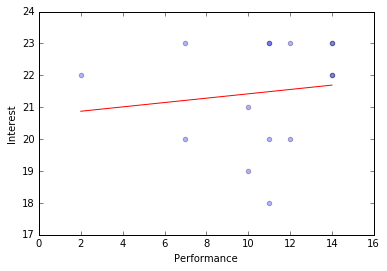

In [18]:
Performance_linspace = np.linspace(groups.Performance.min(), groups.Performance.max(), 100)

plt.xlabel('Performance')
plt.ylabel('Interest')
plt.scatter(groups.Performance, groups.Interest, alpha=0.3)
plt.plot(Performance_linspace, est2.params[0] + est2.params[1] * Performance_linspace, 'r')

## Model \#3:  Prediction of Interest given Mastery-approach goals $P(Interest | Mastery)$
$Interest=\beta_0+\beta_1\cdot Mastery$

In [19]:
est3 = smf.ols(formula='Interest ~ Mastery', data=groups).fit()
short_summary(est3)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,9.7158,3.162,3.072,0.009,2.884 16.547
Mastery,0.9180,0.246,3.734,0.003,0.387 1.449


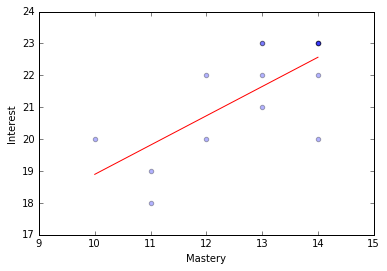

In [20]:
Mastery_linspace = np.linspace(groups.Mastery.min(), groups.Performance.max(), 100)

plt.xlabel('Mastery')
plt.ylabel('Interest')
plt.scatter(groups.Mastery, groups.Interest, alpha=0.3)
plt.plot(Mastery_linspace, est3.params[0] + est3.params[1] * Mastery_linspace, 'r')

## Model \#4: Prediction of Interest given Utility value $P(Interest | Utility)$
$Interest=\beta_0+\beta_1\cdot Utility$

In [21]:
est4 = smf.ols(formula='Interest ~ Utility', data=groups).fit()
short_summary(est4)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,11.5000,2.602,4.420,0.001,5.880 17.120
Utility,0.5320,0.138,3.858,0.002,0.234 0.830


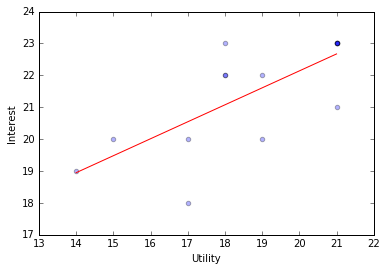

In [24]:
Utility_linspace = np.linspace(groups.Utility.min(), groups.Utility.max(), 100)

plt.xlabel('Utility')
plt.ylabel('Interest')
plt.scatter(groups.Utility, groups.Interest, alpha=0.3)
plt.plot(Utility_linspace, est4.params[0] + est4.params[1] * Utility_linspace, 'r')

## Multiple regression modeling with categorical variables

The multiple regression model describes the score values as a weighted sum of the predictors. Categorical variable $D$ is added to account for two groups in the observed data: a groups with high expectancy of success, and a groups with low expectancy of success. These groups are defined as 1 standard deviation above and below the mean. The regression model under this categorical variable and additive effects is expressed as:  

$$Interest = \beta_0 + \beta_1 Success + \alpha_1 D_1$$

In [27]:
addEst = smf.ols(formula='Interest ~ Success  + label', data=groups).fit()
short_summary(addEst)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,5.0364,7.624,0.661,0.522,-11.744 21.817
label[T.high],-0.9818,1.317,-0.746,0.471,-3.879 1.916
label[T.low],0.9091,1.222,0.744,0.472,-1.780 3.598
Success,1.3636,0.633,2.153,0.054,-0.030 2.758


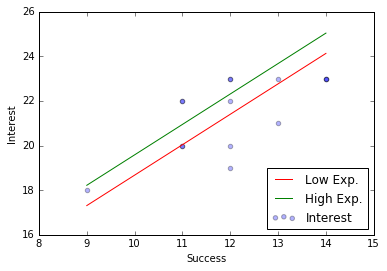

In [28]:
plt.xlabel('Success')
plt.ylabel('Interest')
plt.scatter(groups.Success, groups.Interest, alpha=0.3)
plt.plot(Success_linspace, addEst.params[0] + addEst.params[3] * Success_linspace + addEst.params[2] * 0, 'r',label="Low Exp.")
plt.plot(Success_linspace, addEst.params[0] + addEst.params[3] * Success_linspace + addEst.params[2] * 1, 'g',label="High Exp.")
plt.legend(loc=4)

## Categorical model \#2: Interest given Performance-approach goals $P(Interest|Performance,D=High)$

$$Interest = \beta_0 + \beta_1 Performance + \alpha_1 D_1$$

In [30]:
addEst2 = smf.ols(formula='Interest ~ Performance + label', data=groups).fit()
short_summary(addEst2)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,20.8238,1.641,12.691,0.000,17.212 24.435
label[T.high],1.2404,1.000,1.240,0.241,-0.961 3.442
label[T.low],-0.9292,1.012,-0.919,0.378,-3.156 1.297
Performance,0.0505,0.130,0.389,0.705,-0.236 0.337


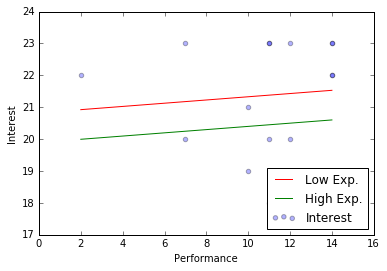

In [34]:
plt.xlabel('Performance')
plt.ylabel('Interest')
plt.scatter(groups.Performance, groups.Interest, alpha=0.3)
plt.plot(Performance_linspace, addEst2.params[0] + addEst2.params[3] * Performance_linspace + addEst2.params[2] * 0, 'r',label="Low Exp.")
plt.plot(Performance_linspace, addEst2.params[0] + addEst2.params[3] * Performance_linspace + addEst2.params[2] * 1, 'g',label="High Exp.")
plt.legend(loc=4)

## Categorical model \#3: Interest given Mastery-approach goals  $P(Interest|Mastery,D=High)$

$$Interest = \beta_0 + \beta_1 Mastery + \alpha_1 D_1$$

In [35]:
addEst3 = smf.ols(formula='Interest ~ Mastery + label', data=groups).fit()
short_summary(addEst3)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,10.8521,3.095,3.507,0.005,4.041 17.663
label[T.high],-0.0104,0.778,-0.013,0.990,-1.722 1.701
label[T.low],-1.3458,0.701,-1.919,0.081,-2.889 0.198
Mastery,0.8646,0.250,3.452,0.005,0.313 1.416


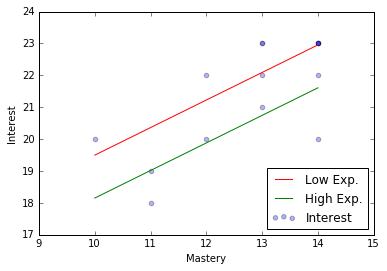

In [36]:
plt.xlabel('Mastery')
plt.ylabel('Interest')
plt.scatter(groups.Mastery, groups.Interest, alpha=0.3)
plt.plot(Mastery_linspace, addEst3.params[0] + addEst3.params[3] * Mastery_linspace + addEst3.params[2] * 0, 'r',label="Low Exp.")
plt.plot(Mastery_linspace, addEst3.params[0] + addEst3.params[3] * Mastery_linspace + addEst3.params[2] * 1, 'g',label="High Exp.")
plt.legend(loc=4)

## Categorical model \#3: Interest given Utility value  $P(Interest|Utility,D=High)$

$$Interest = \beta_0 + \beta_1 Utility + \alpha_1 D_1$$

In [37]:
addEst4 = smf.ols(formula='Interest ~ Utility + label', data=groups).fit()
short_summary(addEst4)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,13.0000,2.988,4.351,0.001,6.424 19.576
label[T.high],0.0800,0.854,0.094,0.927,-1.800 1.960
label[T.low],-0.9067,0.760,-1.194,0.258,-2.579 0.765
Utility,0.4667,0.163,2.858,0.016,0.107 0.826


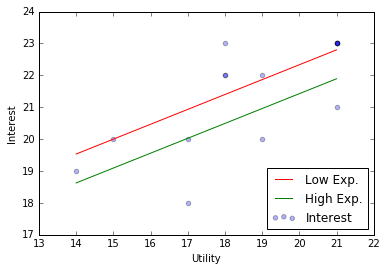

In [38]:
plt.xlabel('Utility')
plt.ylabel('Interest')
plt.scatter(groups.Utility, groups.Interest, alpha=0.3)
plt.plot(Utility_linspace, addEst4.params[0] + addEst4.params[3] * Utility_linspace + addEst4.params[2] * 0, 'r',label="Low Exp.")
plt.plot(Utility_linspace, addEst4.params[0] + addEst4.params[3] * Utility_linspace + addEst4.params[2] * 1, 'g',label="High Exp.")
plt.legend(loc=4)

## Multiple regression modeling with categorical variables and multiplicative effects

The multiple regression model describes the score values as a weighted sum of the predictors. Multiplicative effects are considered in this model as shown below:  

$$Interest = \beta_0 + \beta_1 Success_1 + \alpha_1 D_1 + \alpha_2 (D_1Success_1)$$

In [40]:
mulEst = smf.ols(formula='Interest ~ Success  * label', data=groups).fit()
short_summary(mulEst)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,4.5476,6.357,0.715,0.491,-9.618 18.713
label[T.high],4.4524,11.805,0.377,0.714,-21.850 30.755
label[T.low],-0.0476,7.936,-0.006,0.995,-17.730 17.635
Success,1.4044,0.532,2.638,0.025,0.218 2.590
Success:label[T.high],-0.4044,0.822,-0.492,0.633,-2.236 1.427
Success:label[T.low],0.0956,0.728,0.131,0.898,-1.526 1.717


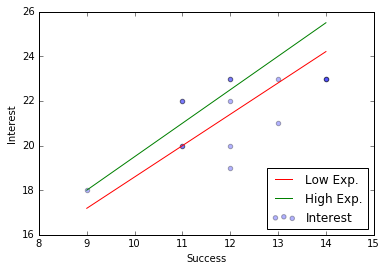

In [42]:
plt.xlabel('Success')
plt.ylabel('Interest')
plt.scatter(groups.Success, groups.Interest, alpha=0.3)
plt.plot(Success_linspace, mulEst.params[0] + mulEst.params[3] * Success_linspace + 
         mulEst.params[2] * 0 + mulEst.params[5] * 0 * Success_linspace, 'r',label="Low Exp.")
plt.plot(Success_linspace, mulEst.params[0] + mulEst.params[3] * Success_linspace + 
         mulEst.params[2] * 1 + mulEst.params[5] * 1 * Success_linspace, 'g',label="High Exp.")
plt.legend(loc=4)

## Model with multiplicative effects \#2: $P(Interest|Performance,D=High)$
$$Interest = \beta_0 + \beta_1 Performance_1 + \alpha_1 D_1 + \alpha_2 (D_1Performance_1)$$

In [43]:
mulEst2 = smf.ols(formula='Interest ~ Performance  * label', data=groups).fit()
short_summary(mulEst2)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,16.1534,2.861,5.647,0.000,9.682 22.625
label[T.high],5.9418,4.240,1.401,0.195,-3.650 15.534
label[T.low],5.4094,3.324,1.627,0.138,-2.110 12.929
Performance,0.4602,0.244,1.883,0.092,-0.093 1.013
Performance:label[T.high],-0.4126,0.378,-1.090,0.304,-1.269 0.443
Performance:label[T.low],-0.5765,0.290,-1.987,0.078,-1.233 0.080


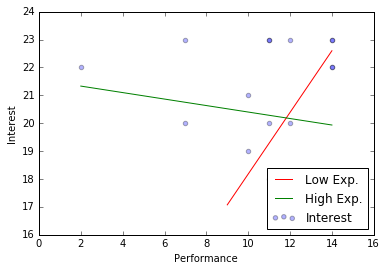

In [44]:
plt.xlabel('Performance')
plt.ylabel('Interest')
plt.scatter(groups.Performance, groups.Interest, alpha=0.3)
plt.plot(Success_linspace, mulEst2.params[0] + mulEst2.params[3] * Performance_linspace + 
         mulEst2.params[2] * 0 + mulEst2.params[5] * 0 * Performance_linspace, 'r',label="Low Exp.")
plt.plot(Performance_linspace, mulEst2.params[0] + mulEst2.params[3] * Performance_linspace + 
         mulEst2.params[2] * 1 + mulEst2.params[5] * 1 * Performance_linspace, 'g',label="High Exp.")
plt.legend(loc=4)

## Model with multiplicative effects \#3: $P(Interest|Mastery,D=High)$
$$Interest = \beta_0 + \beta_1 Mastery_1 + \alpha_1 D_1 + \alpha_2 (D_1Mastery_1)$$

In [46]:
mulEst3 = smf.ols(formula='Interest ~ Mastery  * label', data=groups).fit()
short_summary(mulEst3)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,9.4259,4.459,2.114,0.064,-0.660 19.512
label[T.high],-0.4259,15.470,-0.028,0.979,-35.421 34.569
label[T.low],2.5741,7.177,0.359,0.728,-13.662 18.810
Mastery,0.9815,0.363,2.705,0.024,0.161 1.802
Mastery:label[T.high],0.0185,1.147,0.016,0.987,-2.577 2.614
Mastery:label[T.low],-0.3148,0.574,-0.549,0.597,-1.613 0.983


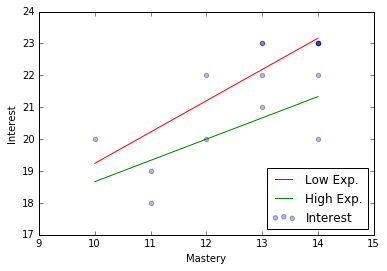

In [47]:
plt.xlabel('Mastery')
plt.ylabel('Interest')
plt.scatter(groups.Mastery, groups.Interest, alpha=0.3)
plt.plot(Mastery_linspace, mulEst3.params[0] + mulEst3.params[3] * Mastery_linspace + 
         mulEst3.params[2] * 0 + mulEst3.params[5] * 0 * Mastery_linspace, 'r',label="Low Exp.")
plt.plot(Mastery_linspace, mulEst3.params[0] + mulEst3.params[3] * Mastery_linspace + 
         mulEst3.params[2] * 1 + mulEst3.params[5] * 1 * Mastery_linspace, 'g',label="High Exp.")
plt.legend(loc=4)

## Model with multiplicative effects \#4: $P(Interest|Utility,D=High)$
$$Interest = \beta_0 + \beta_1 Utility_1 + \alpha_1 D_1 + \alpha_2 (D_1Utility_1)$$

In [48]:
mulEst4 = smf.ols(formula='Interest ~ Utility  * label', data=groups).fit()
short_summary(mulEst4)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,11.5818,3.209,3.609,0.006,4.323 18.841
label[T.high],14.4182,9.447,1.526,0.161,-6.953 35.790
label[T.low],-6.4390,12.830,-0.502,0.628,-35.463 22.585
Utility,0.5455,0.176,3.101,0.013,0.148 0.943
Utility:label[T.high],-0.7121,0.469,-1.518,0.163,-1.773 0.349
Utility:label[T.low],0.3117,0.719,0.433,0.675,-1.315 1.938


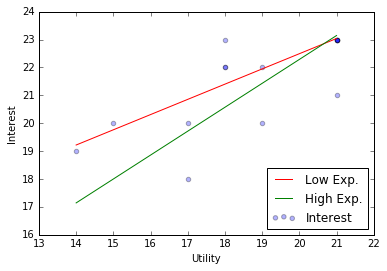

In [49]:
plt.xlabel('Utility')
plt.ylabel('Interest')
plt.scatter(groups.Utility, groups.Interest, alpha=0.3)
plt.plot(Utility_linspace, mulEst4.params[0] + mulEst4.params[3] * Utility_linspace + 
         mulEst4.params[2] * 0 + mulEst4.params[5] * 0 * Utility_linspace, 'r',label="Low Exp.")
plt.plot(Utility_linspace, mulEst4.params[0] + mulEst4.params[3] * Utility_linspace + 
         mulEst4.params[2] * 1 + mulEst4.params[5] * 1 * Utility_linspace, 'g',label="High Exp.")
plt.legend(loc=4)